__Lesson_3. от 28.02.2019__

In [1]:
import pandas as pd
import warnings
import statsmodels as sm
import scipy.stats as st
import scipy as sp
import numpy as np
from sklearn.preprocessing import StandardScaler
import os
import tqdm

import seaborn as sns
sns.set()
import matplotlib
import matplotlib.pyplot as plt
import plotly as py
import plotly.graph_objs as go
py.tools.set_credentials_file(username='alr.popkov', api_key='yJgfJog0jfMx23Ja60oR')

%matplotlib inline
#%matplotlib qt
%config InlineBackend.figure_format = 'retina'

In [3]:
os.listdir(os.getcwd())

['.ipynb_checkpoints',
 '4 ряда данных.xlsx',
 'lesson_3_price_revenue.ipynb',
 'lesson_3_price_volume.ipynb',
 'lesson_3_volume_revenue.ipynb',
 'temp-plot.html',
 'план на занятие.docx',
 'торговля.xls']

__Задачи:__

1. Загрузить данные
2. Построить однородные диаграммы
3. Подобрать плотность
4. Проверить гипотезу (логнормальность распределения)
5. Построить облако рассеяния в натуральных значениях
6. Построить облако рассеяния в логарифмах

Загрузим данные

In [4]:
data = pd.read_excel(r'торговля.xls',sheet_name=r'Торговля', delimeter=',')

In [5]:
data.shape

(3085, 4)

In [6]:
data.head()

,code,price,volume,revenue
0,43001,97.40001,358,34869.20358
1,43002,39.22001,812,31846.64812
2,43003,21.43001,1455,31180.66455
3,43004,7.66001,3900,29874.03900
4,43005,36.01001,826,29744.26826


Изобразим гистограммы, с ядерной оценкой плотности kde

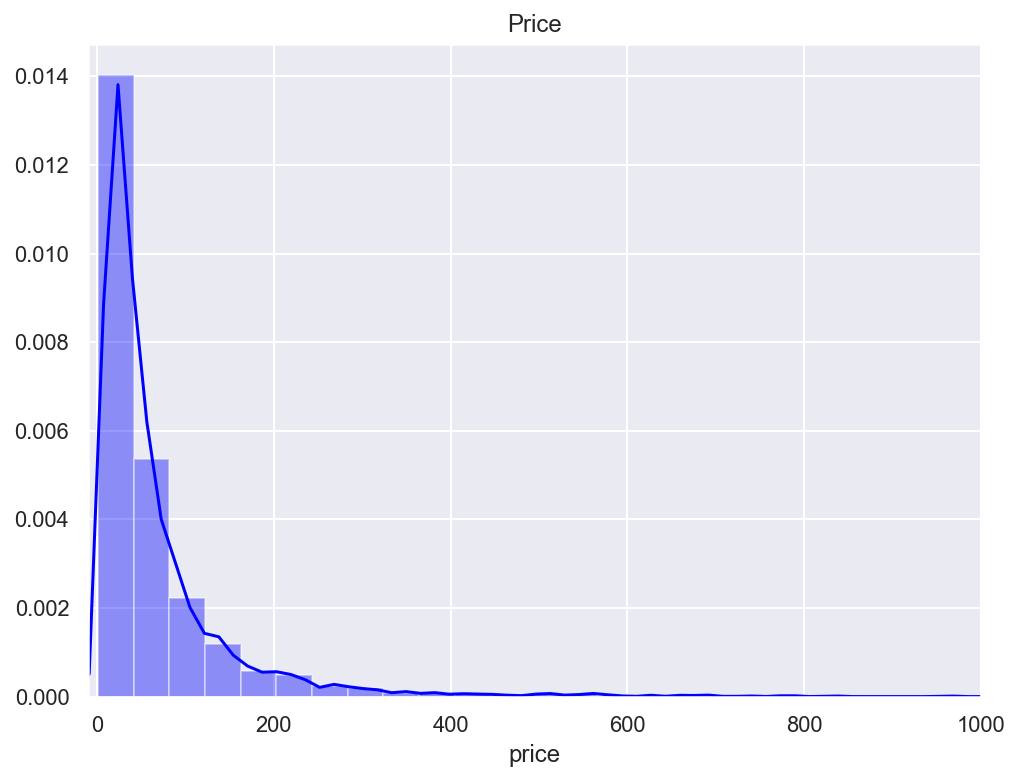

In [7]:
fig = plt.figure(figsize = (8,6))
sns.distplot(data['price'], color='blue')
plt.title('Price')
plt.xlim((-10,1000))
plt.show()

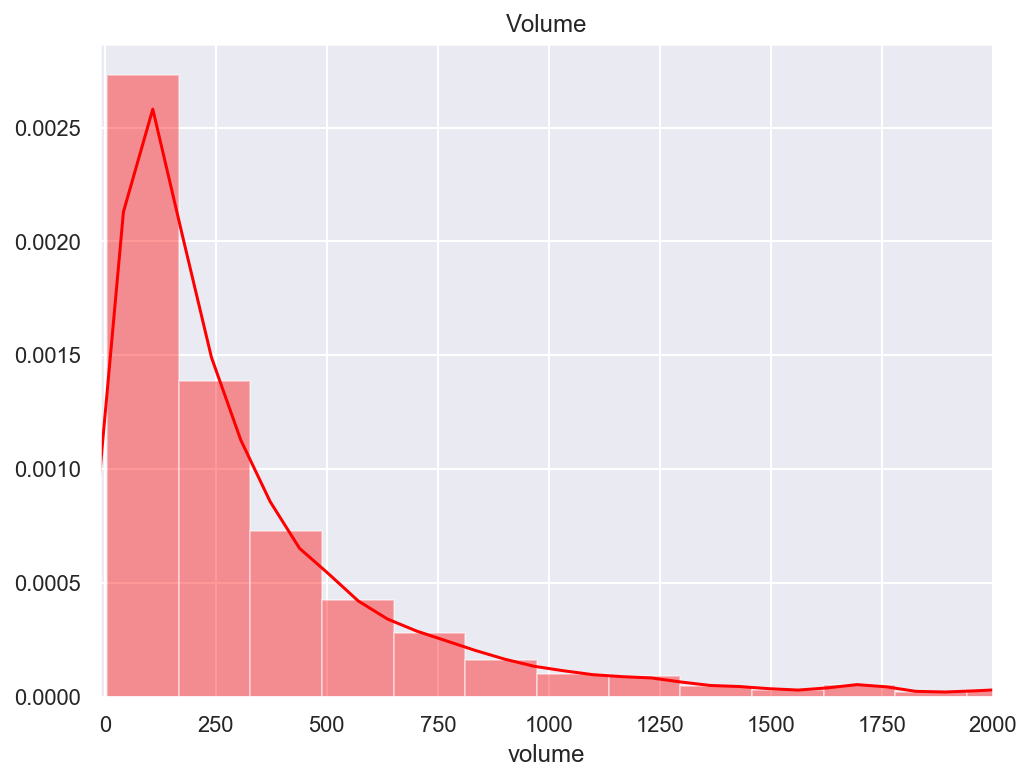

In [8]:
fig = plt.figure(figsize = (8,6))
sns.distplot(data['volume'], color='red')
plt.title('Volume')
plt.xlim((-10,2000))
plt.show()

Прологарифмируем данные:

In [9]:
data['log_price'] = data['price'].apply(lambda x: np.log(x))
data['log_volume'] = data['volume'].apply(lambda x: np.log(x))

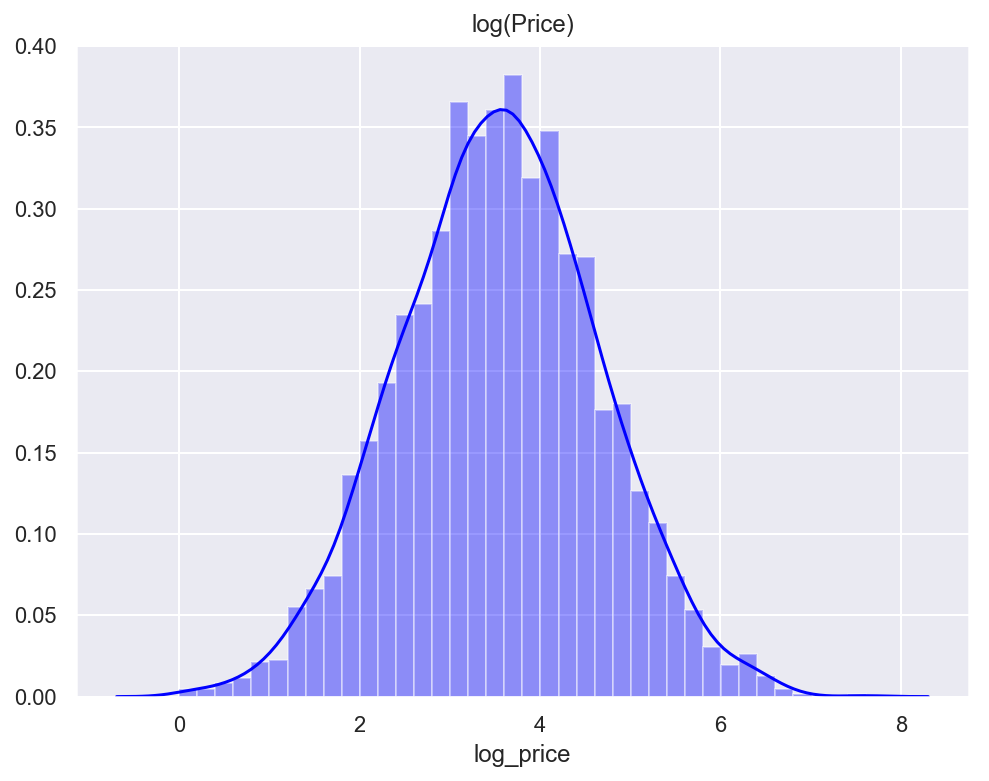

In [10]:
fig = plt.figure(figsize = (8,6))
sns.distplot(data['log_price'], color='blue')
plt.title('log(Price)')
plt.show()

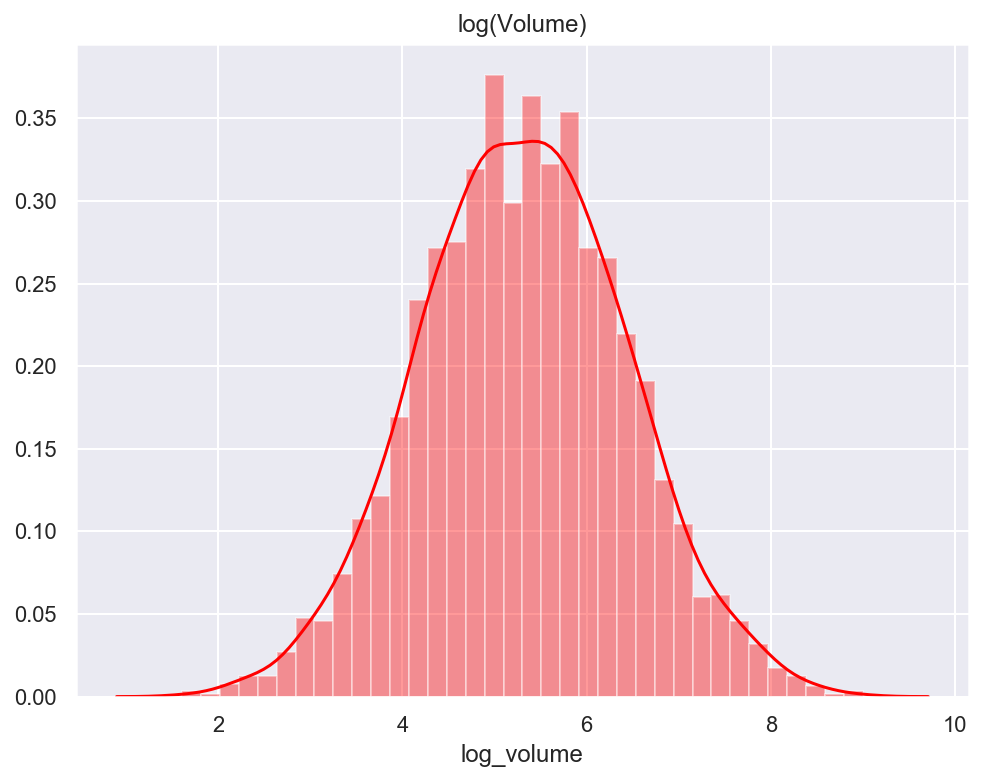

In [11]:
fig = plt.figure(figsize = (8,6))
sns.distplot(data['log_volume'], color='red')
plt.title('log(Volume)')
plt.show()

In [12]:
def best_fit_distribution(data, bins=200, ax=None):
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Distributions to check
    DISTRIBUTIONS = [        
                    st.norm,
                    st.lognorm
                    ]

    best_distribution = st.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf

    for distribution in DISTRIBUTIONS:

        try:
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                params = distribution.fit(data)

                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax)
                    end
                except Exception:
                    pass

                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse

        except Exception:
            pass

    return (best_distribution.name, best_params)

def make_pdf(dist, params, size=10000):

    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf

In [13]:
def plot_best_fit(data):
    
    best_fit_name, best_fit_params = best_fit_distribution(data, 200)
    best_dist = getattr(st, best_fit_name)
    
    pdf = make_pdf(best_dist, best_fit_params)

    plt.figure(figsize=(8,6))
    ax = pdf.plot(lw=2, label='PDF', legend=True)
    data.plot(kind='hist', bins=50, density=True, alpha=0.5, label='Data', legend=True, ax=ax)


    param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
    param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_fit_params)])
    dist_str = '{}({})'.format(best_fit_name, param_str)

    ax.set_title(u'Best fit distribution ' + dist_str)

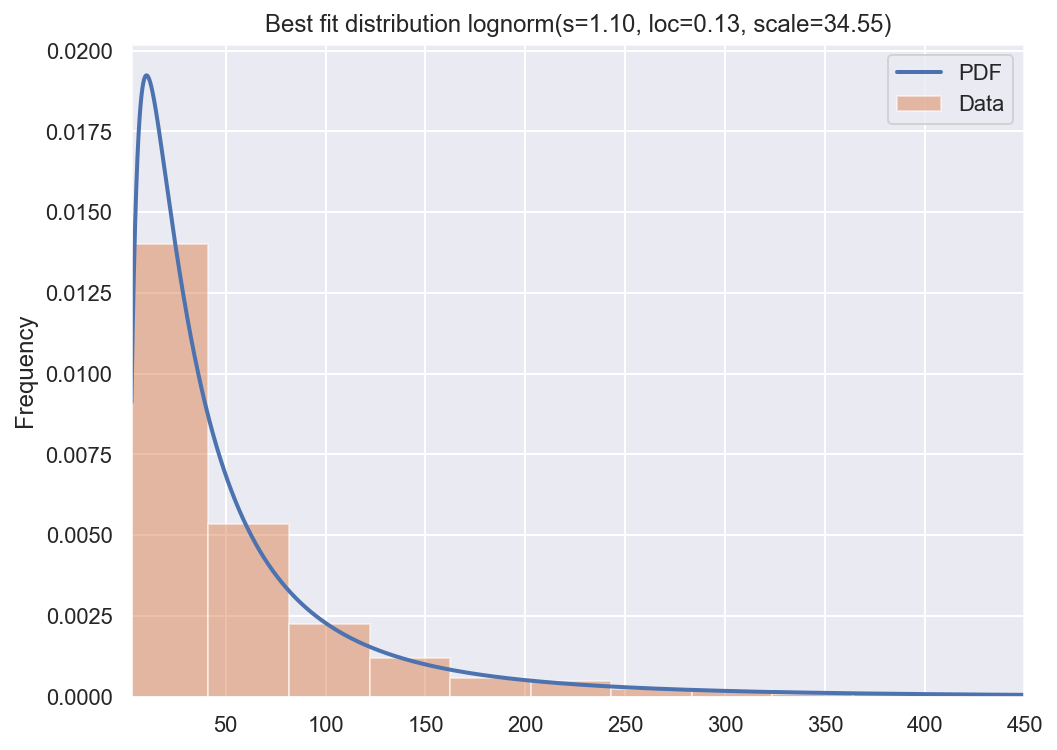

In [14]:
plot_best_fit(data['price'])

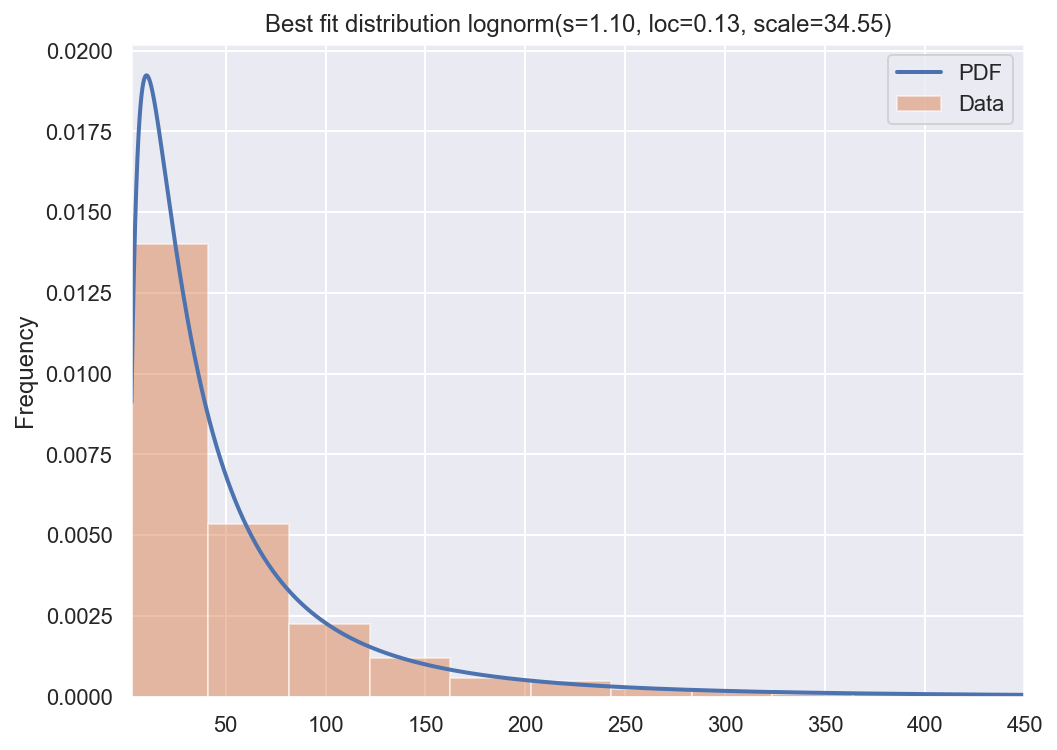

In [15]:
plot_best_fit(data['price'])

Проведем тест на нормальность в логарифмах данных, т.е. на логнормальность: 

Используем тест Харке-Бера

In [16]:
jb = st.jarque_bera(data['log_price'])
print('statistic: {}\np-value: {}'.format(jb[0], jb[1]))

statistic: 0.4188698980746276
p-value: 0.8110423968058061


In [17]:
jb = st.jarque_bera(data['log_volume'])
print('statistic: {}\np-value: {}'.format(jb[0], jb[1]))

statistic: 1.0852833107592095
p-value: 0.581210863837535


Гипотеза H0: S=0, K=3 о логнормальности остатков (наличия ассиметрии и эксцесса, соотв. нормальным) не отвергается, т.к. p-value для обоих тестов > 0.05

Изобразим изначальное облако точек в данных.

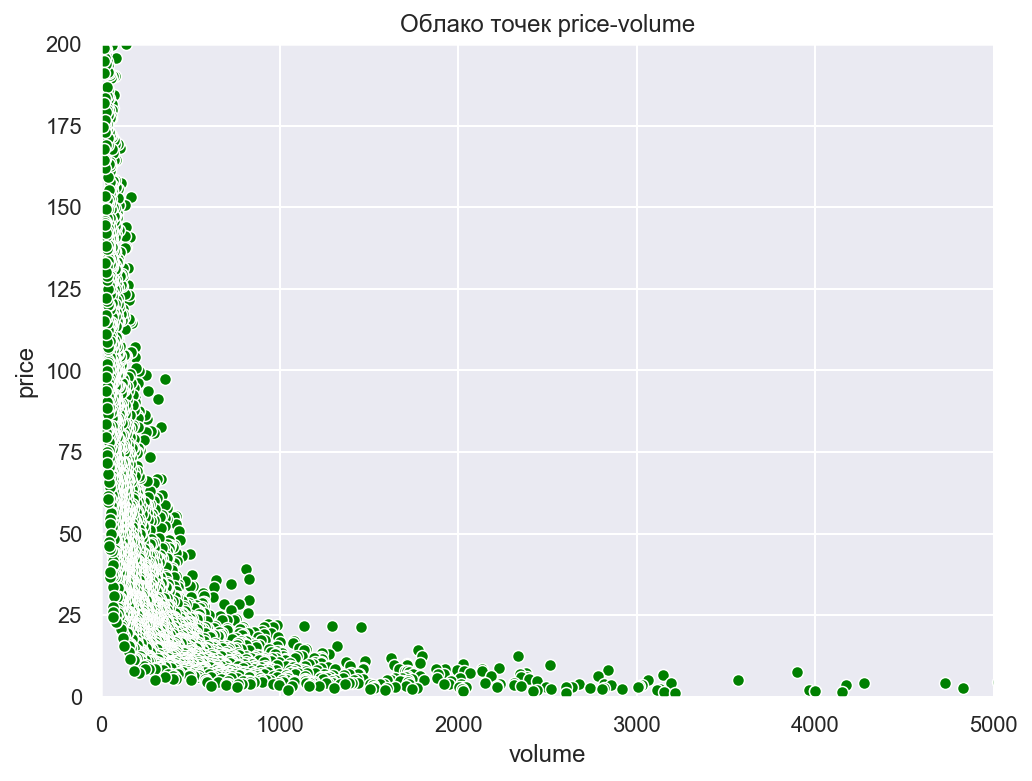

In [18]:
fig = plt.figure(figsize = (8,6))
sns.scatterplot(data = data, x = 'volume', y ='price', color = 'green')
plt.xlim((0, 5000))
plt.ylim((0, 200))
plt.title('Облако точек price-volume')
plt.show()

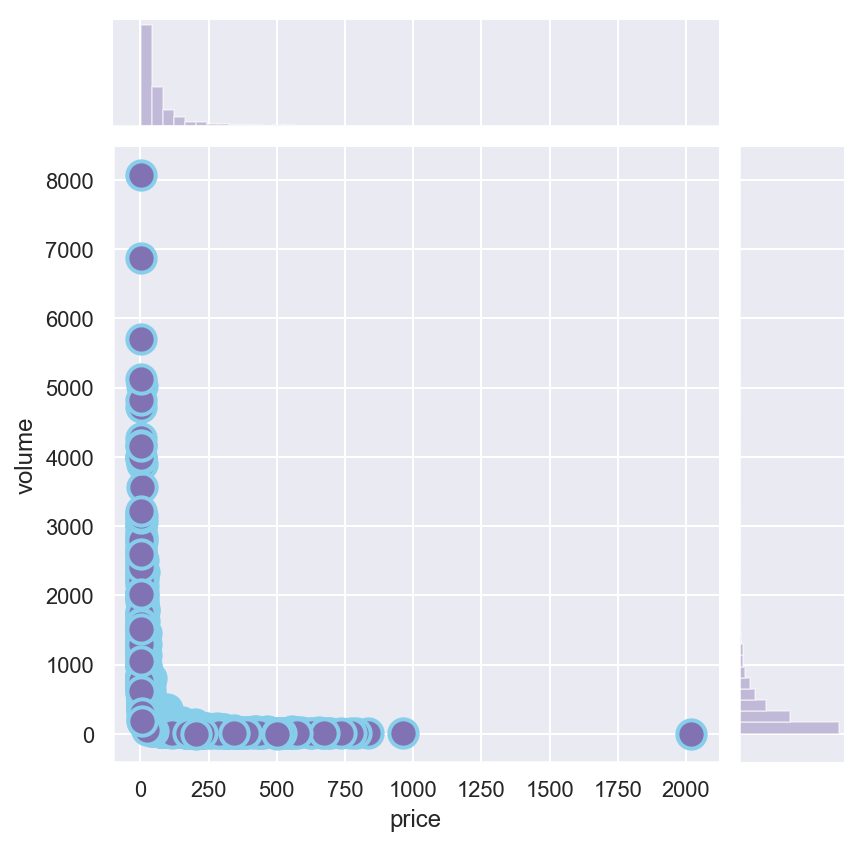

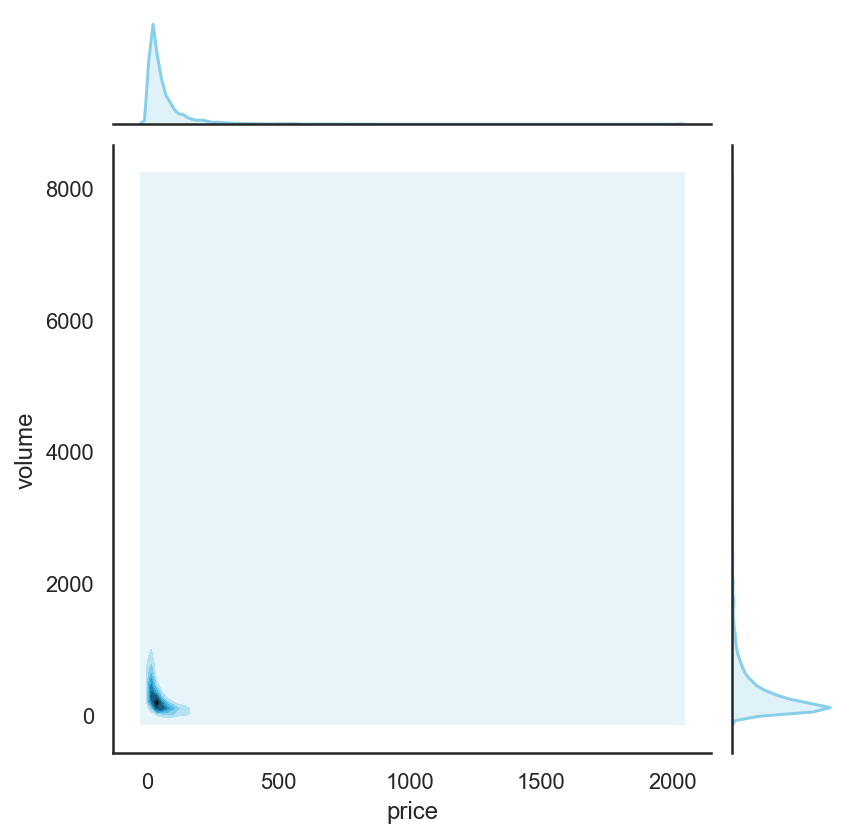

In [19]:
sns.jointplot(x=data['price'], y=data['volume'], kind='scatter', s=200, color='m', edgecolor="skyblue", linewidth=2)
 
# Custom the color
sns.set(style="white", color_codes=True)
sns.jointplot(x=data['price'], y=data['volume'], kind='kde', color="skyblue")

Прологарифмируем наши данные.

In [20]:
data['log_price'] = data['price'].apply(lambda x: np.log(x))
data['log_volume'] = data['volume'].apply(lambda x: np.log(x))

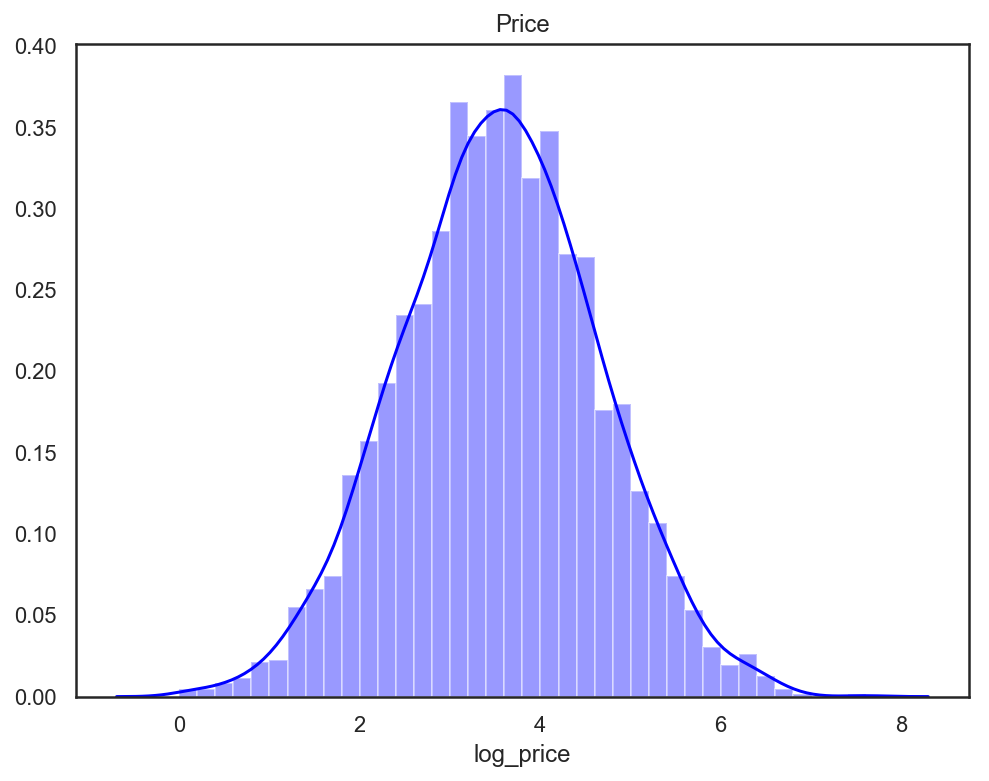

In [21]:
fig = plt.figure(figsize = (8,6))
sns.distplot(data['log_price'], color='blue')
plt.title('Price')
plt.show()

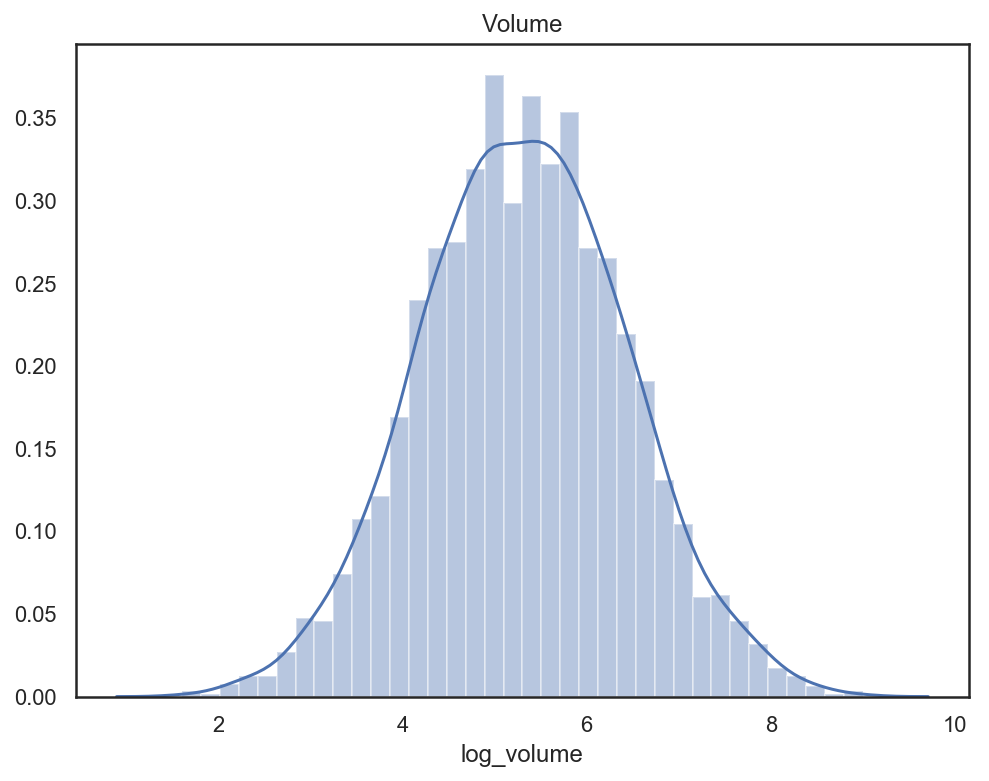

In [22]:
fig = plt.figure(figsize = (8,6))
sns.distplot(data['log_volume'])
plt.title('Volume')
plt.show()

Теперь изобразим облако точек в логарифмах данных. На графике отчетливо виден эллипс рассеивания, показывающий обратную зависимость.

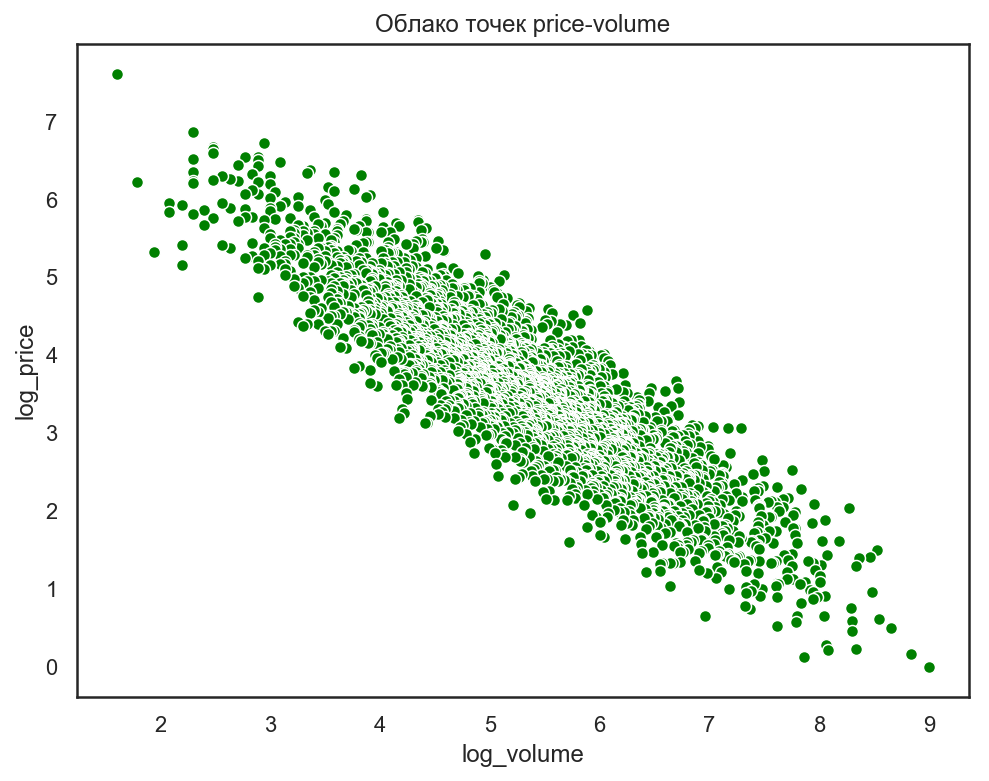

In [23]:
fig = plt.figure(figsize = (8,6))
sns.scatterplot(data = data, x = 'log_volume', y ='log_price', color = 'green')
plt.title('Облако точек price-volume')
plt.show()

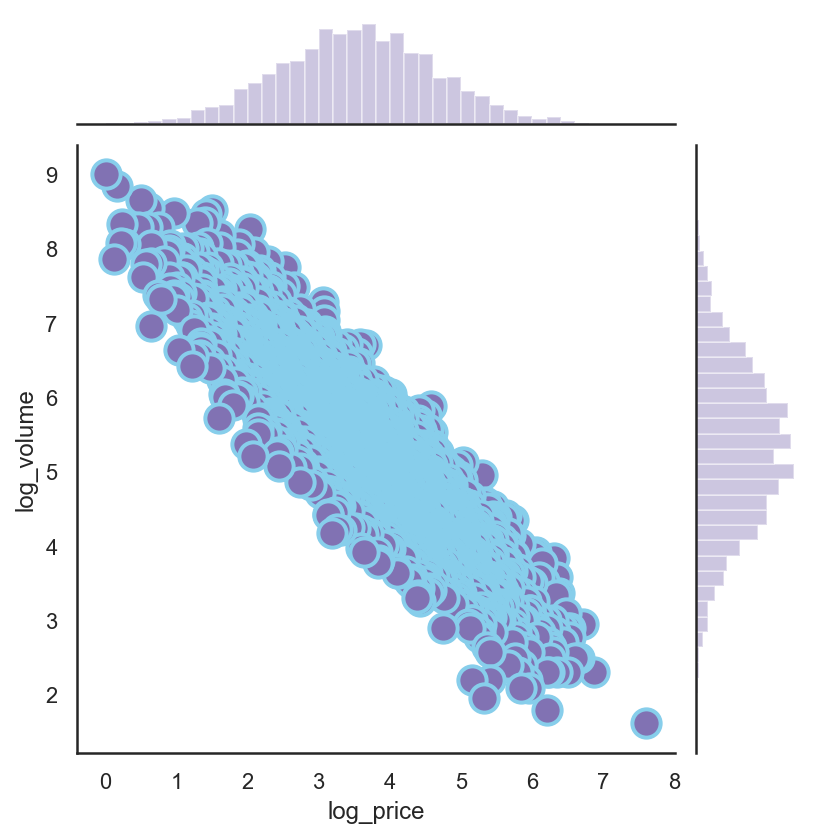

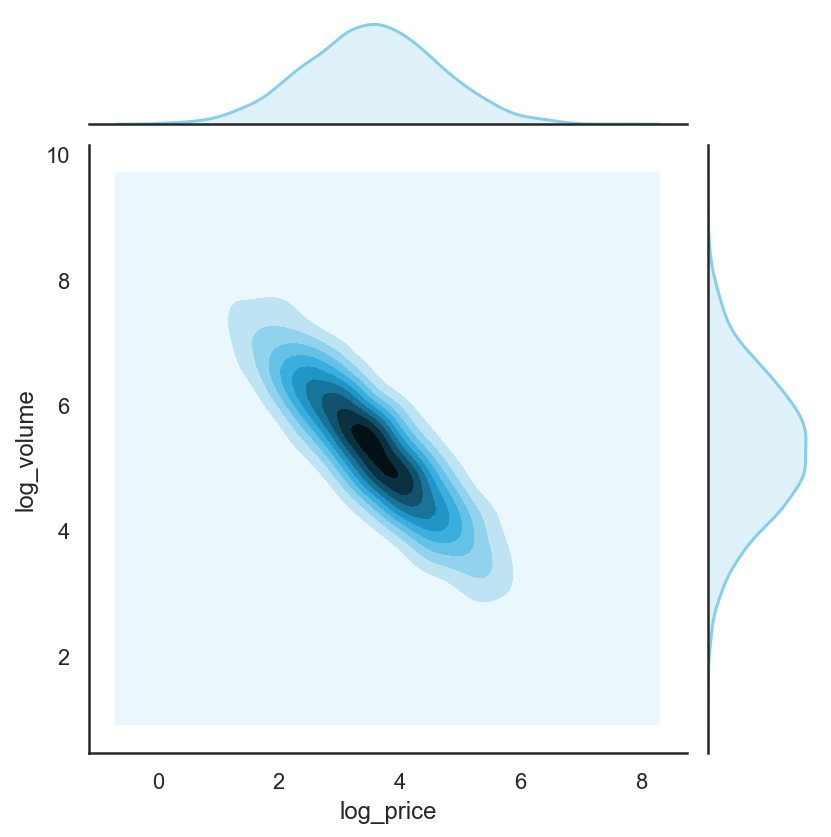

In [24]:
sns.jointplot(x=data['log_price'], y=data['log_volume'], kind='scatter', s=200, color='m', edgecolor="skyblue", linewidth=2)
 
# Custom the color
sns.set(style="white", color_codes=True)
sns.jointplot(x=data['log_price'], y=data['log_volume'], kind='kde', color="skyblue")

Найдем корреляцию между этими показателями:

In [25]:
data[['log_price', 'log_volume']].corr()

,log_price,log_volume
log_price,1.000000,-0.892663
log_volume,-0.892663,1.000000


In [26]:
# Статистики распределения
sigma_x = np.std(data['log_price'])
sigma_y = np.std(data['log_volume'])
mean_x = np.mean(data['log_price'])
mean_y = np.mean(data['log_volume'])
rho = np.corrcoef(data['log_price'], data['log_volume'])[0][1]

Построим поверхность с помощью формулы двумерного номрального распределения. Для этого напишем функцию генерации точек плотности распределения.

In [27]:
# Построение плотности вероятности функции
class pdf(object):
    def __init__(self):
        pass
        
    def A(self, sigma_x, sigma_y, rho):
        return 1/(2*np.pi*sigma_x*sigma_y*( 1-rho**2 )**0.5)

    def B(self, rho):
        return -1/( 2*(1-rho**2) )

    def C(self, sigma_x):
        return 1/sigma_x**2

    def D(self, sigma_x, sigma_y, rho):
        return -2*rho/(sigma_x*sigma_y)

    def E(self, sigma_y):
        return 1/sigma_y**2
 
    def get_func(self, sigma_x, sigma_y, rho, x, y, mean_x, mean_y):
        self.sigma_x = sigma_x
        self.sigma_y = sigma_y
        self.rho = rho
        self.x = x
        self.y = y
        self.mean_x = mean_x
        self.mean_y = mean_y
        
        a = pdf().A(sigma_x, sigma_y, rho)
        b = pdf().B(rho)
        c = pdf().C(sigma_x)
        d = pdf().D(sigma_x, sigma_y, rho)
        e = pdf().E(sigma_y)
        
        return a*np.exp(b*(  c*(x-mean_x)**2 + d*(x-mean_x)*(y-mean_y) + e*(y-mean_y)**2 ))
    
    def get_func_log(self, sigma_x, sigma_y, rho, x, y, mean_x, mean_y):
        self.sigma_x = sigma_x
        self.sigma_y = sigma_y
        self.rho = rho
        self.x = x
        self.y = y
        self.mean_x = mean_x
        self.mean_y = mean_y
        
        a = pdf().A(sigma_x, sigma_y, rho)
        b = pdf().B(rho)
        c = pdf().C(sigma_x)
        d = pdf().D(sigma_x, sigma_y, rho)
        e = pdf().E(sigma_y)
        return a*np.exp(b*(  c*(np.log(x)-mean_x)**2 + d*(np.log(x)-mean_x)*(np.log(y)-mean_y) + e*(np.log(y)-mean_y)**2 ))/(x*y)
               

In [28]:
# Обработка 3d графики
from mpl_toolkits.mplot3d import Axes3D

In [29]:
class NormalDensity(object):
    # Конструктор класса
    def __init__(self,
                 x,y,
                 sigma_x, sigma_y,
                 rho,
                 mean_x, mean_y,
                 figsize):
        self.x = x
        self.y = y
        self.sigma_x = sigma_x
        self.sigma_y = sigma_y
        self.rho = rho
        self.mean_x = mean_x
        self.mean_y = mean_y
        self.figsize = figsize
 
                   
    def plot(self, angle, angle2, xtitle, ytitle, ztitle, log = False):
        self.angle = angle
        self.angle2 = angle2

        # Генерируем сетку для построения поверхности
        x, y = np.meshgrid(self.x, self.y)
        
        if log == False:
            z = pdf().get_func(sigma_x, 
                               sigma_y, 
                               rho, 
                               x, 
                               y, 
                               mean_x, 
                               mean_y)
        else:
            z = pdf().get_func_log(sigma_x, 
                                   sigma_y, 
                                   rho, 
                                   x, 
                                   y,
                                   mean_x, 
                                   mean_y)

        # Создаем фигуру
        fig = plt.figure(figsize = self.figsize)
        ax = fig.gca(projection = '3d')
        surf  = ax.plot_surface(x, y, z, cmap=plt.cm.coolwarm, linewidth=0, antialiased=False)
        
        # Раскраска поверхности
        fig.colorbar(surf, shrink=0.7, aspect = 5)
        
        ax.set_xlabel(xtitle)
        ax.set_ylabel(ytitle)
        ax.set_zlabel(ztitle)
        
        # Придание угла
        ax.view_init(angle, angle2)
        fig.tight_layout()
        plt.show()
        
        
    def plot_contour(self, xtitle, ytitle, ztitle, log):
        fig = plt.figure(figsize = self.figsize)
        X, Y = np.meshgrid(self.x, self.y)
        if log == False:
            Z = pdf().get_func(sigma_x, 
                           sigma_y, 
                           rho, 
                           X, 
                           Y,
                           mean_x, 
                           mean_y)
        else:
            Z = pdf().get_func_log(sigma_x, 
               sigma_y, 
               rho, 
               X, 
               Y,
               mean_x, 
               mean_y)
        
        plt.subplot(131)
        cset = plt.contourf(X, Y, Z, cmap=plt.cm.coolwarm)
        plt.xlabel(xtitle)
        plt.ylabel(ytitle)
        plt.subplot(132)
        cset = plt.contourf(Y, Z, X, cmap=plt.cm.coolwarm)
        plt.xlabel(ytitle)
        plt.ylabel(ztitle)
        plt.subplot(133)
        cset = plt.contourf(X, Z, Y, cmap=plt.cm.coolwarm)
        plt.xlabel(xtitle)
        plt.ylabel(ztitle)
        
        fig.tight_layout()
        plt.show()
        
    def plotly_plot(self, title, xaxis, yaxis, zaxis, log = False):
        x, y = np.meshgrid(self.x, self.y)
        
        if log == False:
            z = pdf().get_func(
                               sigma_x, 
                               sigma_y, 
                               rho, 
                               x, 
                               y, 
                               mean_x, 
                               mean_y
                              )
        else:
            z = pdf().get_func_log(sigma_x, 
               sigma_y, 
               rho, 
               x, 
               y,
               mean_x, 
               mean_y)

        data = [go.Surface(z=z, x = x, y = y)]
        
        layout = go.Layout(
            title='Surface',
            autosize=False,
            width=self.figsize[0],
            height=self.figsize[1],
    
            scene = dict(
            zaxis = dict(title = zaxis ),
            yaxis = dict(title = yaxis ),
            xaxis = dict(title = xaxis ),)
                            )
        return go.Figure(data=data, layout=layout)   

Добавим возможность интерактивного вращения поверхности.

In [30]:
import ipywidgets as widgets
def interact_1(sigma_x, sigma_y, rho, mean_x, mean_y, log):
    widgets.interact(
                  NormalDensity(
                  np.linspace(-1, 8, 100),
                  np.linspace(-2, 10, 100),
                  sigma_x, sigma_y,
                  rho,
                  mean_x, mean_y,
                  figsize = (12, 8)

                  ).plot, 
                  angle =   widgets.IntSlider(
                                value=30,
                                min=0,
                                max=360,
                                step=1,
                                description='Angle_1:',
                                disabled=False,
                                continuous_update=False,
                                orientation='horizontal',
                                readout=True,
                                readout_format='d'),
                   angle2 =   widgets.IntSlider(
                                value=90,
                                min=0,
                                max=360,
                                step=1,
                                description='Angle_2:',
                                disabled=False,
                                continuous_update=False,
                                orientation='horizontal',
                                readout=True,
                                readout_format='d'),
                xtitle ='Price',
                ytitle = 'Volume',
                ztitle = 'Sales',
                log = log
                    )

In [31]:
# Прорисовка поверхности
interact_1(sigma_x, sigma_y, rho, mean_x, mean_y, False)

interactive(children=(IntSlider(value=30, continuous_update=False, description='Angle_1:', max=360), IntSlider(value=90, continuous_update=False, description='Angle_2:', max=360), Text(value='Price', description='xtitle'), Text(value='Volume', description='ytitle'), Text(value='Sales', description='ztitle'), Checkbox(value=False, description='log'), Output()), _dom_classes=('widget-interact',))

In [32]:
fig =  NormalDensity(
                  np.linspace(-1, 8, 100),
                  np.linspace(-2, 10, 100),
                  sigma_x, sigma_y,
                  rho,
                  mean_x, mean_y,
                  figsize = (700, 700)

                  ).plotly_plot('Surface', 'Price', 'Volume', 'Sales', False)
py.plotly.iplot(fig, filename = '3d_sales_surface')

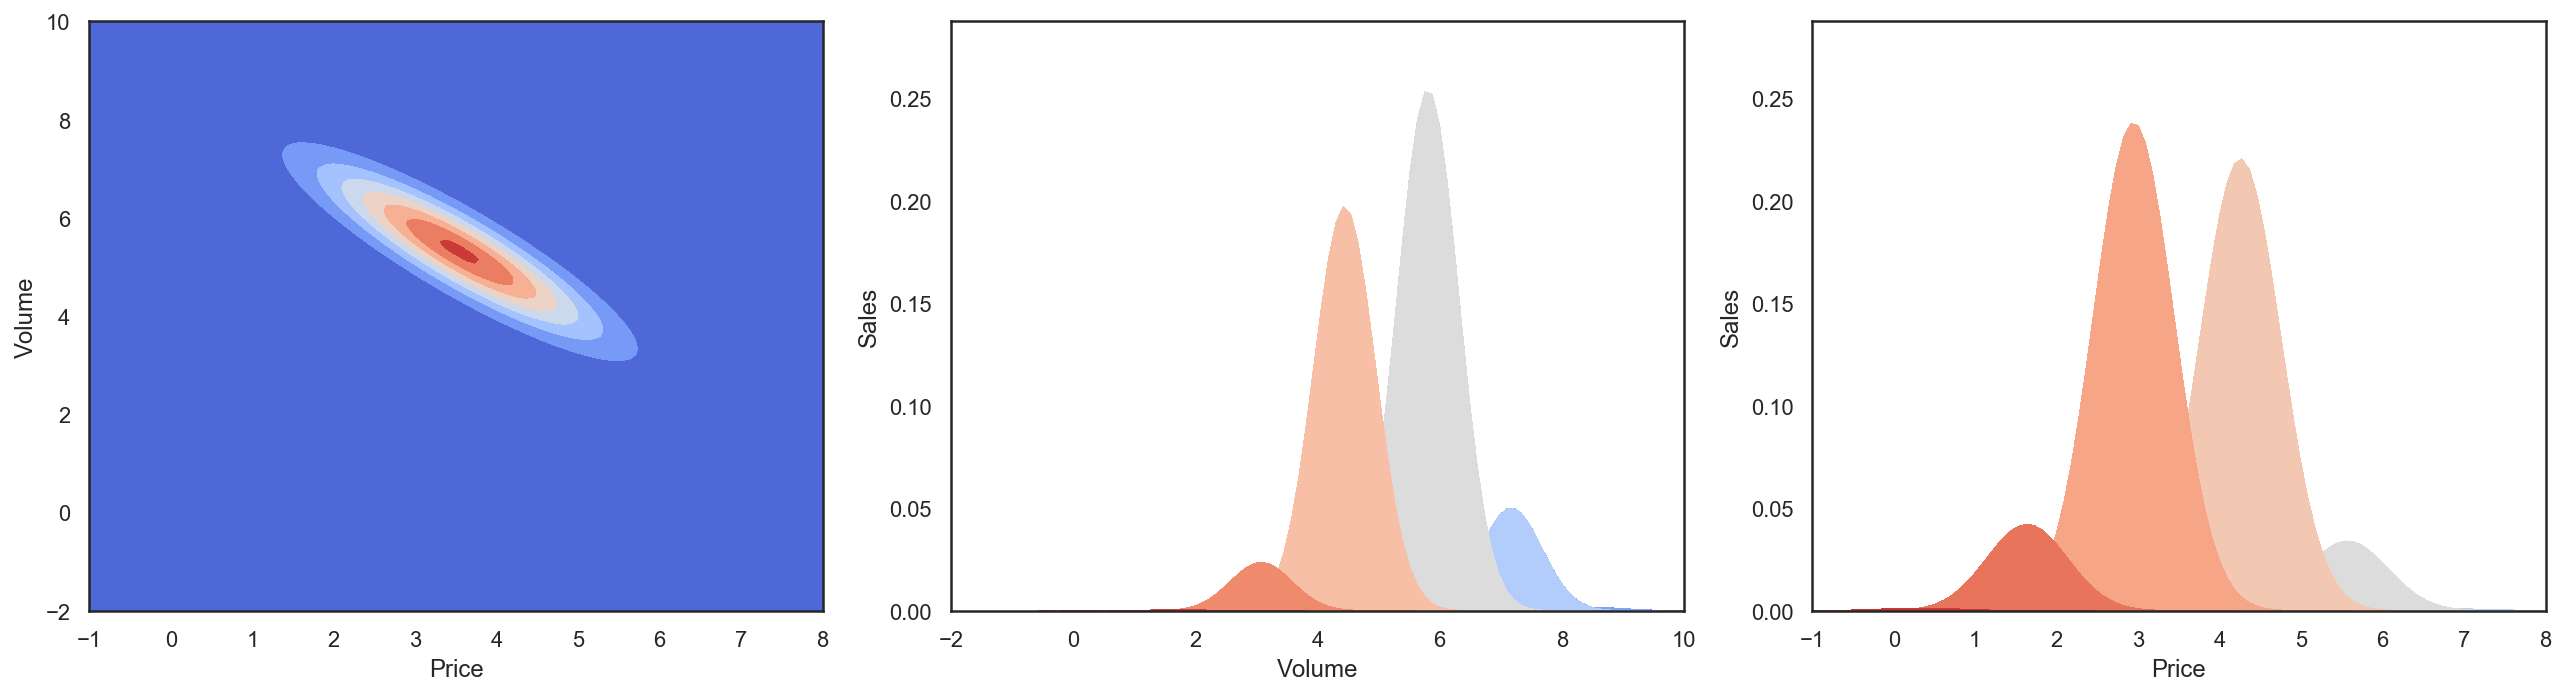

In [33]:
NormalDensity(
              np.linspace(-1, 8, 100),
              np.linspace(-2, 10, 100),
              sigma_x, sigma_y,
              rho,
              mean_x, mean_y,
              figsize = (18, 5)
             ).plot_contour('Price', 'Volume', 'Sales', log = False)

In [34]:
def interact_2(sigma_x, sigma_y, rho, mean_x, mean_y, log):
    widgets.interact(
                  NormalDensity(
                  np.linspace(1, 200, 1000),
                  np.linspace(1, 1000, 1000),
                  sigma_x, sigma_y,
                  rho,
                  mean_x, mean_y,
                  figsize = (12, 8)

                  ).plot, 

                  angle =   widgets.IntSlider(
                                value=75,
                                min=0,
                                max=360,
                                step=1,
                                description='Angle_1:',
                                disabled=False,
                                continuous_update=False,
                                orientation='horizontal',
                                readout=True,
                                readout_format='d'),
                  angle2 =   widgets.IntSlider(
                        value=120,
                        min=0,
                        max=360,
                        step=1,
                        description='Angle_2:',
                        disabled=False,
                        continuous_update=False,
                        orientation='horizontal',
                        readout=True,
                        readout_format='d'),
                xtitle ='Price',
                ytitle = 'Volume',
                ztitle = 'Sales',
                log = log
                    )

In [35]:
interact_2(sigma_x, sigma_y, rho, mean_x, mean_y, log = True)

interactive(children=(IntSlider(value=75, continuous_update=False, description='Angle_1:', max=360), IntSlider(value=120, continuous_update=False, description='Angle_2:', max=360), Text(value='Price', description='xtitle'), Text(value='Volume', description='ytitle'), Text(value='Sales', description='ztitle'), Checkbox(value=True, description='log'), Output()), _dom_classes=('widget-interact',))

In [36]:
fig =  NormalDensity(
                  np.linspace(1, 200, 300),
                  np.linspace(1, 1000, 300),
                  sigma_x, sigma_y,
                  rho,
                  mean_x, mean_y,
                  figsize = (700, 700)

                  ).plotly_plot('Surface', 'Price', 'Volume', 'Sales', True)
py.plotly.iplot(fig, filename = '3d_sales_surface_2')

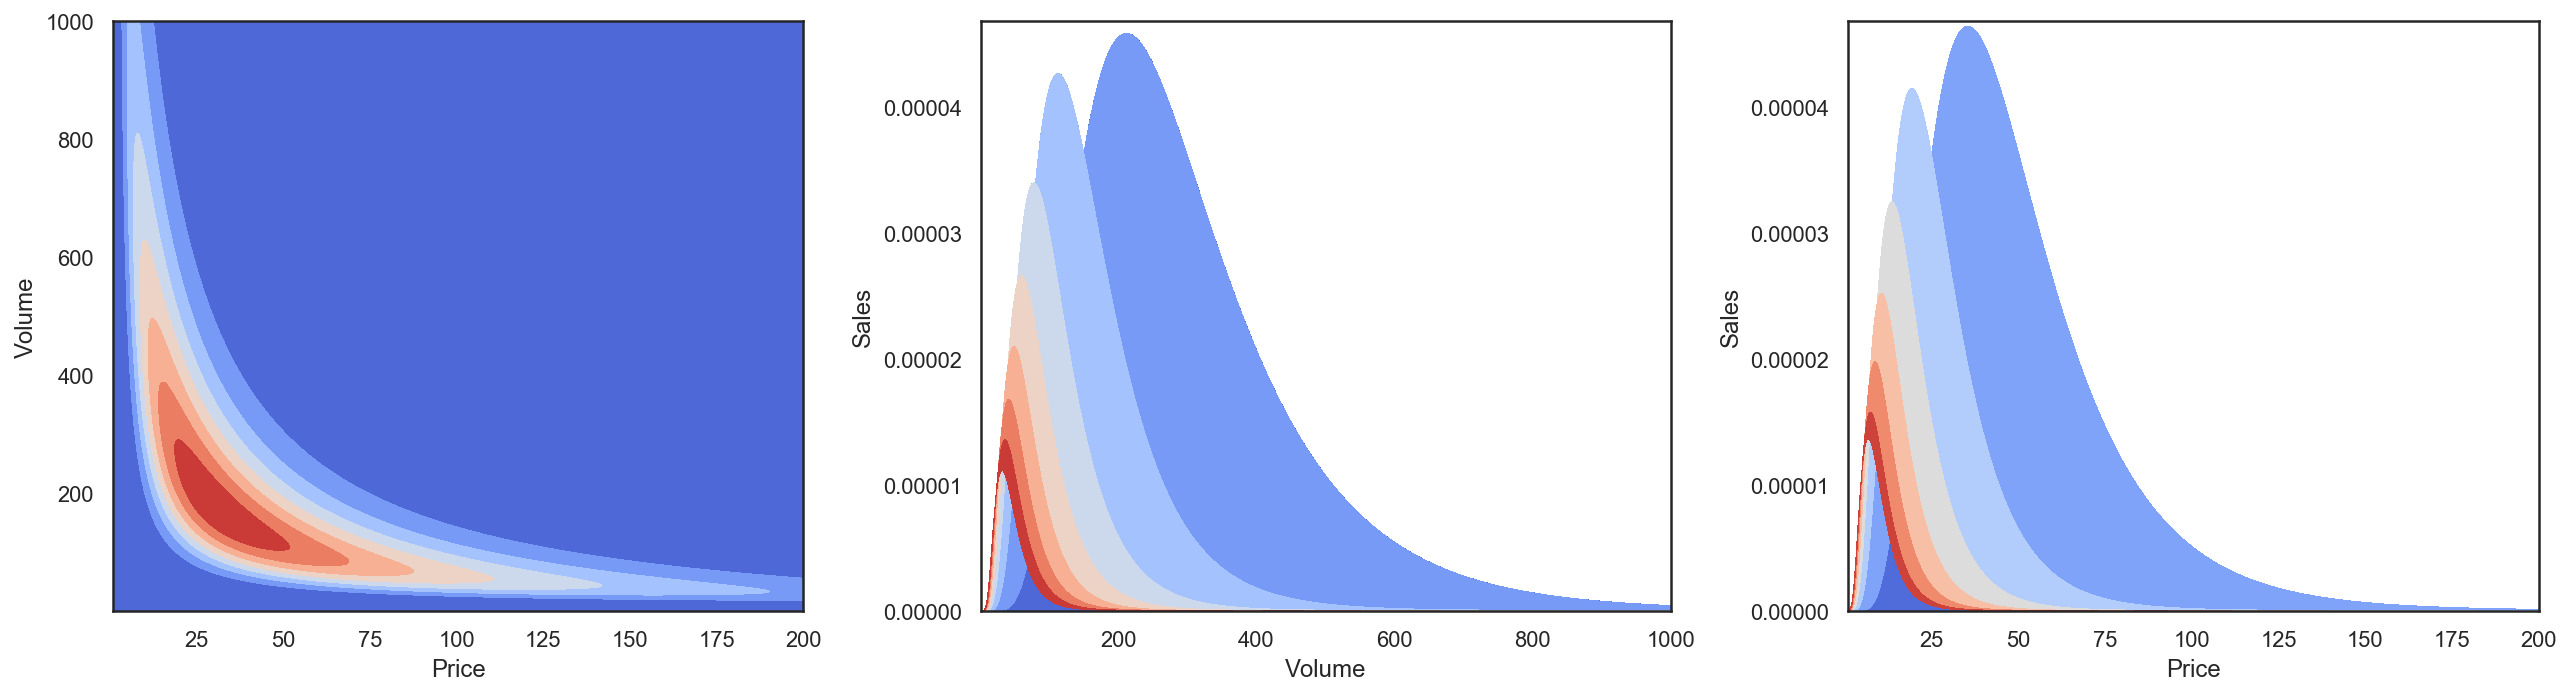

In [37]:
NormalDensity(
                  np.linspace(1, 200, 1000),
                  np.linspace(1, 1000, 1000),
                  sigma_x, sigma_y,
                  rho,
                  mean_x, mean_y,
                  figsize = (18, 5)

                  ).plot_contour('Price', 'Volume', 'Sales', log = True)

Чтобы понять, сколько необходимо товара заказать, необходимо подумать, какой квантиль взять.

Можно взять моду, медиану, среднее. Далее зависит от выбранного обоснования.

In [38]:
def Moda(mu_v, mu_p, rho, sigma_v, sigma_p, p):
    A = np.exp(mu_v - rho*(sigma_v/sigma_p)*mu_p - (sigma_v**2)*(1-rho**2))
    B = rho*(sigma_v/sigma_p)
    return A*(p**B)

def Median(mu_v, mu_p, rho, sigma_v, sigma_p, p):
    AA = np.exp(mu_v - rho*(sigma_v/sigma_p)*mu_p)
    B = rho*(sigma_v/sigma_p)
    return AA*(p**B)

def Expectation(mu_v, mu_p, rho, sigma_v, sigma_p, p):
    AAA = np.exp(mu_v - rho*(sigma_v/sigma_p)*mu_p + 0.5*(sigma_v**2)*(1-rho**2))
    B = rho*(sigma_v/sigma_p)
    return AAA*(p**B)

Нарисуем распределение по моде, медиане и матожидании

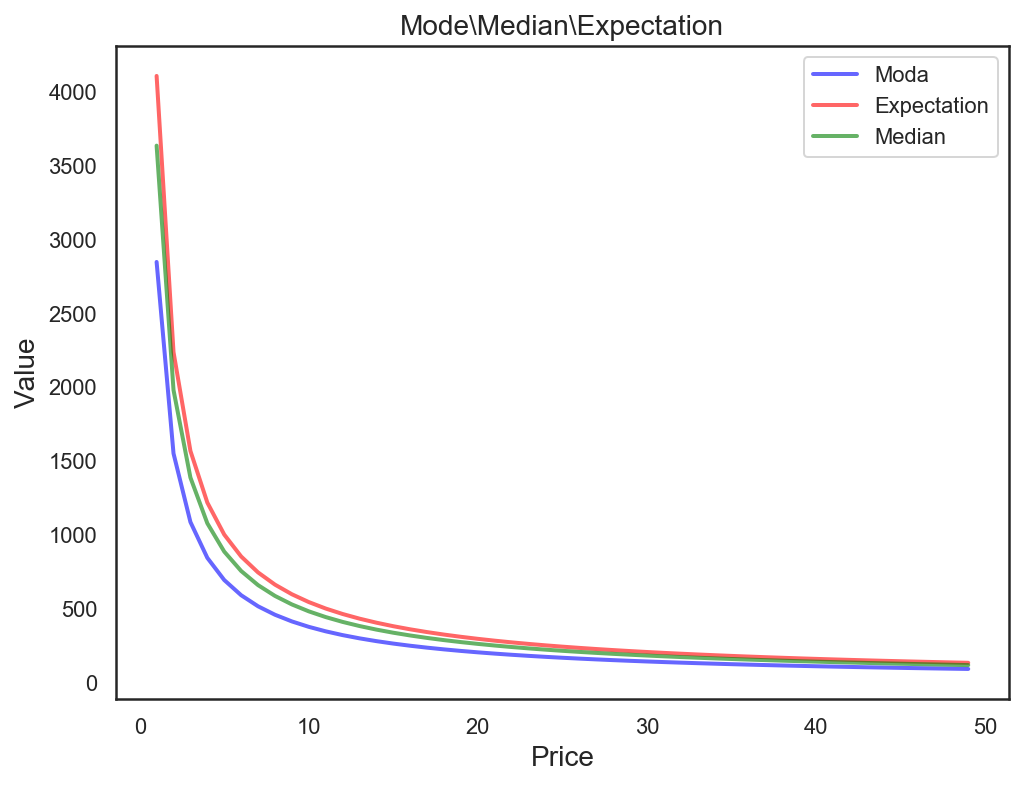

In [39]:
def plot_stats(mean_x, mean_y, rho, sigma_x, sigma_y, range_):
    """
    Параметры:
    Args:
        mean_x -среднее по цене
        mean_y -среднее по количеству
        rho -корреляция 
        sigma_x -стандотклон по цене
        sigma_y -стандотклон по количеству
        range_ -размах цен для прорисовки
    Return: plot 'Mode\Median\Expectation'
        
    """
    price = [x for x in range(1, range_)]
    volume_median = [Median(mean_x, mean_y, rho, sigma_x, sigma_y, x) for x  in price]

    price = [x for x in range(1, 50)]
    volume_exp = [Expectation(mean_x, mean_y, rho, sigma_x, sigma_y, x) for x  in price]

    price = [x for x in range(1, 50)]
    volume_moda = [Moda(mean_x, mean_y, rho, sigma_x, sigma_y, x) for x  in price]

    fig = plt.figure(figsize = (8,6))
    plt.plot(price, volume_moda, color = 'blue', alpha = 0.6, label ='Moda', linewidth=2.0)
    plt.plot(price, volume_exp, color = 'red', alpha = 0.6, label ='Expectation', linewidth=2.0)
    plt.plot(price, volume_median, color = 'green', alpha = 0.6, label ='Median', linewidth=2.0)
    plt.title('Mode\Median\Expectation', fontsize = 14)
    plt.ylabel('Value', fontsize = 14)
    plt.xlabel('Price', fontsize = 14)
    plt.legend()

    plt.show()

plot_stats(mean_x, mean_y, rho, sigma_x, sigma_y, 50)

__Построение эллипсов с вероятностью попадания точки__

In [40]:
from matplotlib.patches import Ellipse

In [41]:
def A(sigma_x, sigma_y, rho):
    return 1/(2*np.pi*sigma_x*sigma_y*( 1-rho**2 )**0.5)

def B(rho):
    return -1/( 2*(1-rho**2) )

def C(sigma_x):
    return 1/sigma_x**2

def D(sigma_x, sigma_y, rho):
    return -2*rho/(sigma_x*sigma_y)

def E(sigma_y):
    return 1/sigma_y**2

In [42]:
def eigsorted(cov):
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    return vals[order], vecs[:,order]

def plot_ellips(x, y, figsize):
    nstd = [x for x in range(1,4)]
    colors = ['red', 'green', 'black']
    confs = [0.683, 0.954, 0.997]
    ells = []
    
    fig = plt.figure(figsize = figsize)
    ax = plt.subplot(111)
    for std, col in zip(nstd, colors):
    
        cov = np.cov(x, y)
        vals, vecs = eigsorted(cov)
        theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))
        w, h = 2 * std * np.sqrt(vals)
        
        ell = Ellipse(xy=(np.mean(x), np.mean(y)),
                      width=w, height=h,
                      angle=theta, color=col,
                      lw=3, alpha = 0.7)
        ells.append(ell)
        
        ell.set_facecolor('none')
        ax.add_artist(ell)
    ax.legend(ells, [f'Confidence: {c}' for c in confs], fontsize = 16)
    plt.scatter(x, y, alpha = 0.5, s = 15)
    plt.show()

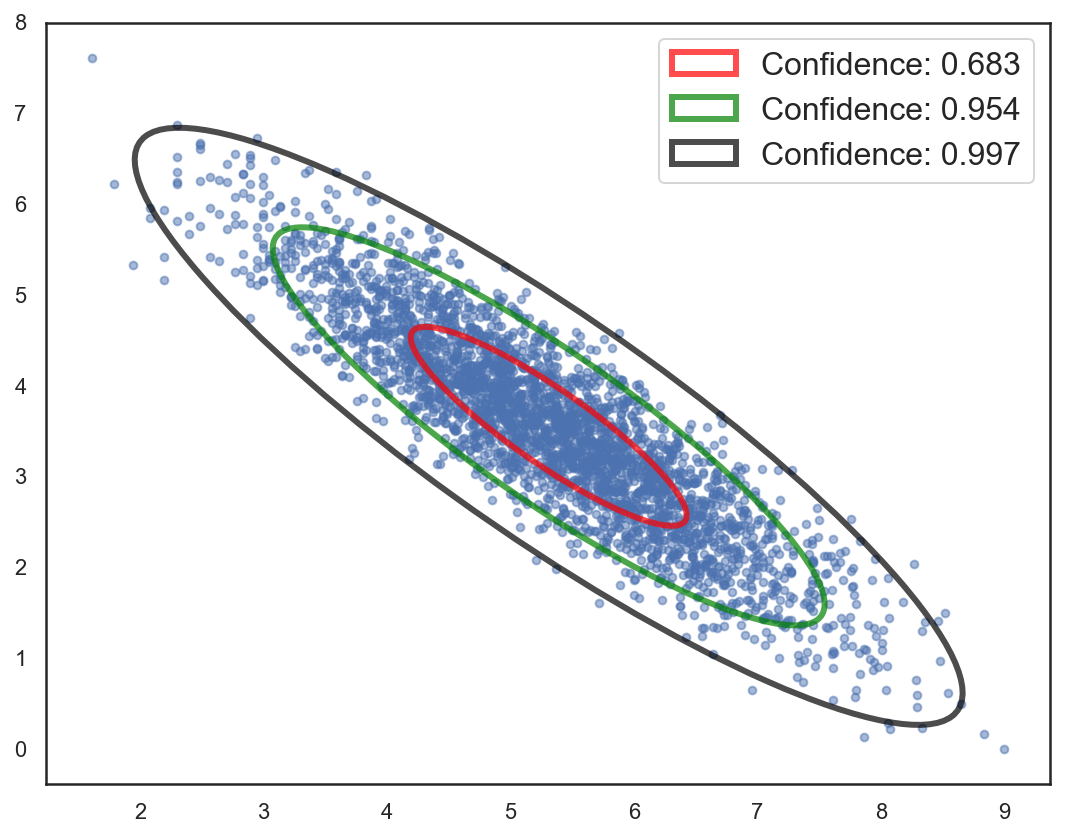

In [43]:
plot_ellips(data['log_volume'].values, data['log_price'].values, (9,7))

In [44]:
# Вариант 2. Эллипс
# Задаем уровень достоверности

def plot_ellipse_conf(er, data, datx, daty, figsize, real = False):
    sigma_x, sigma_y = data[datx].std(), data[daty].std()
    mean_x, mean_y = np.mean(data[datx]), np.mean(data[daty])
    rho = np.corrcoef(data[datx], data[daty])[0][1]
    
    #er = 0.95
    colors = ['black', 'green', 'red']
    fig = plt.figure(figsize = figsize)
    plt.title('Эллипсы с заданной доверительной областью', fontsize = 16)
    for param, c in zip(er, colors):
        kf = np.sqrt(-2*np.log(1-param))
        tt = np.linspace(0.01, 2*np.pi+0.01, num = 100)

        A_ = A(sigma_x, sigma_y, rho)
        B_ = B(rho)
        C_ = C(sigma_x)
        D_ = D(sigma_x, sigma_y, rho)
        E_ = E(sigma_y)

        tg2a = D_/(C_-E_)
        cos2a = 1/np.sqrt(1+tg2a**2)
        cosa = np.sqrt(0.5*(1+cos2a))
        sina = np.sqrt(0.5*(1-cos2a))

        a = kf*(np.sqrt(2)*np.sqrt(1-rho**2))/np.sqrt(C_*cosa**2+D_*cosa*sina+E_*sina**2)
        b = kf*(np.sqrt(2)*np.sqrt(1-rho**2))/np.sqrt(C_*sina**2-D_*cosa*sina+E_*cosa**2)

        xstr = a*np.cos(tt)
        ystr = b*np.sin(tt)

        X = xstr*cosa-ystr*sina+mean_x
        Y = xstr*sina+ystr*cosa+mean_y
        expx = np.exp(X)
        expy = np.exp(Y)

        # Эллипс
        if real:
            plt.plot(expx, expy ,lw=3, color=c, label = f'Confidence: {param}', alpha = 0.8)
        else:
            plt.plot(X, Y ,lw=3, color=c, label = f'Confidence: {param}', alpha = 0.8)
            
    if real:
        plt.scatter(data[datx.split('_')[1]], data[daty.split('_')[1]], alpha = 0.2)
    else:
        plt.scatter(data[datx], data[daty], alpha = 0.2)
        
    
    plt.legend(fontsize = 14)
    if real:
        plt.xlim((0, 1000))
        plt.ylim((0, 1000))
        plt.xlabel(datx.split('_')[1], fontsize = 14)
        plt.ylabel(daty.split('_')[1], fontsize = 14)
    else:
        plt.xlabel(datx, fontsize = 14)
        plt.ylabel(daty, fontsize = 14)
    plt.show()

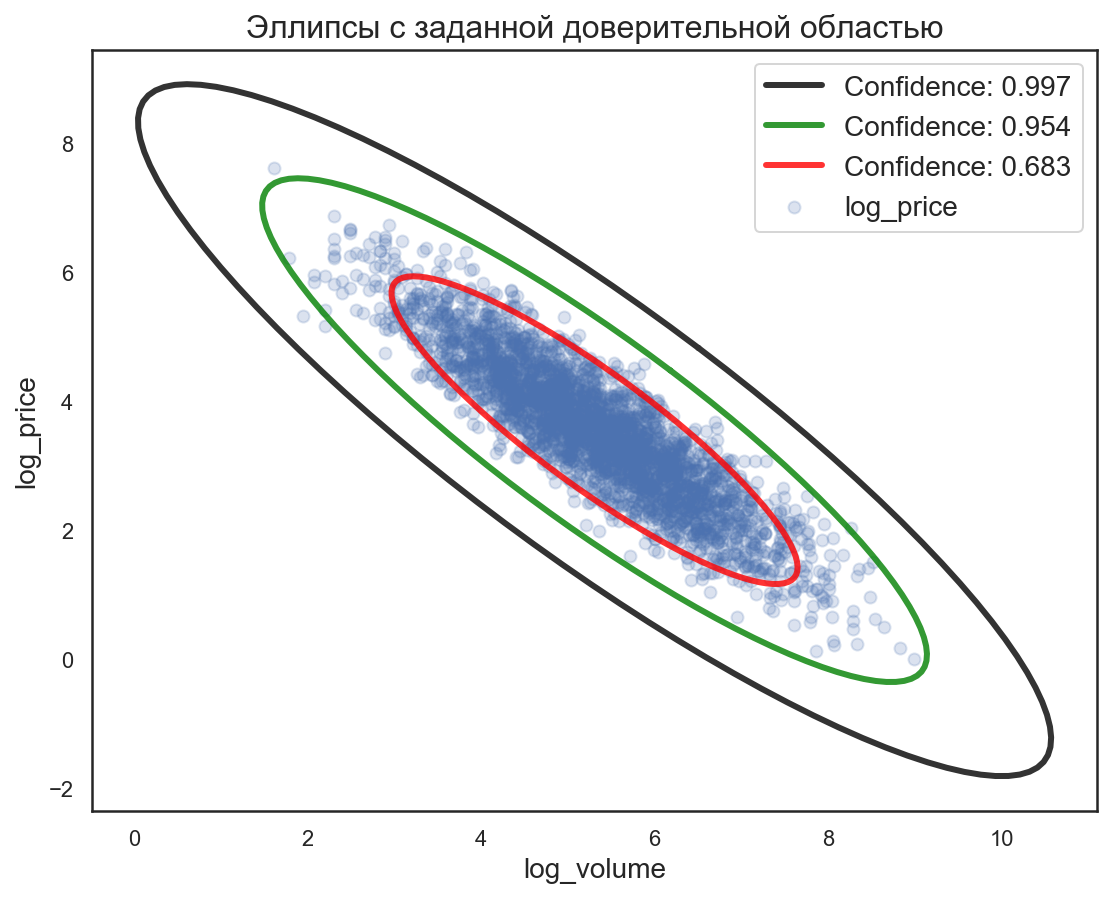

In [45]:
plot_ellipse_conf([0.997, 0.954, 0.683],data, 
                  'log_volume','log_price', (9,7))

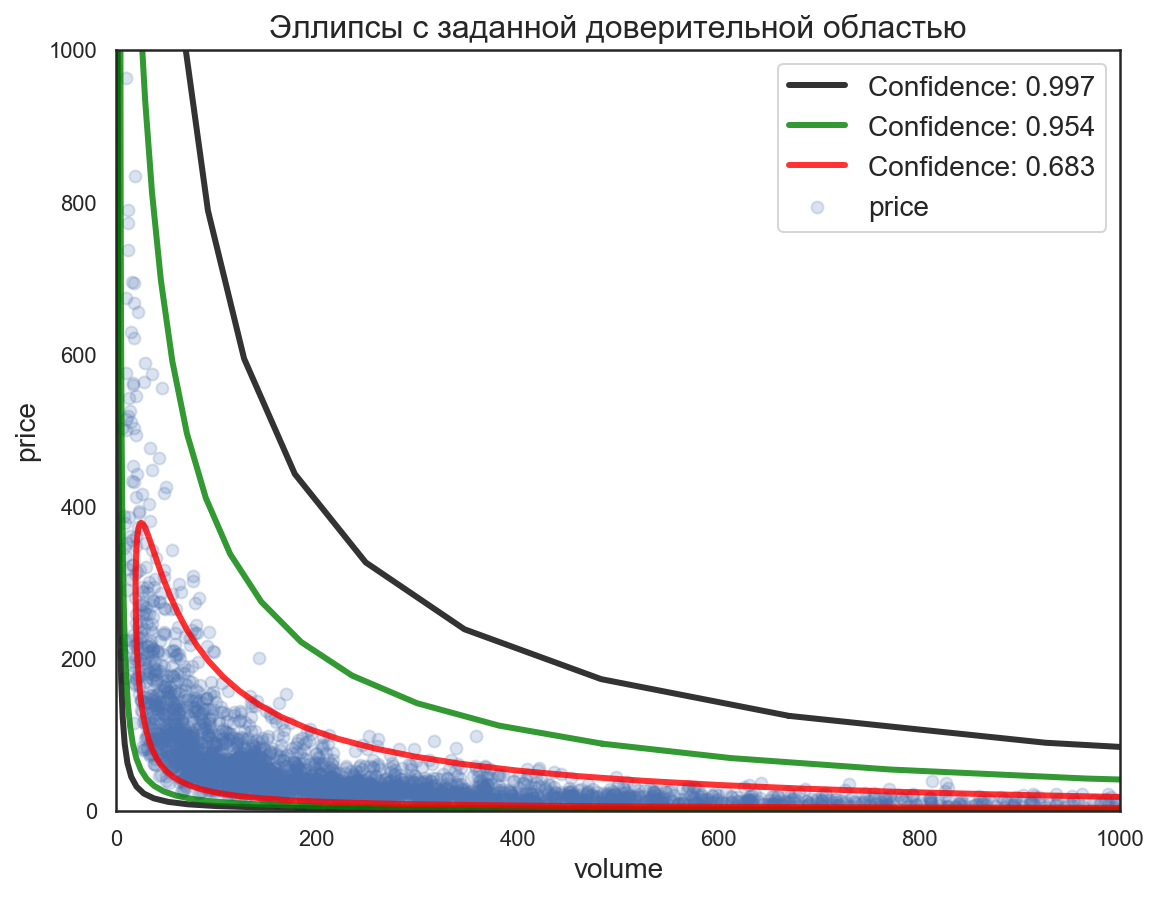

In [46]:
plot_ellipse_conf([0.997, 0.954, 0.683],data, 
                  'log_volume', 'log_price', (9,7), real = True)

__Критерий согласия для двумерного распределения__

Алгоритм тестирования:

 1. Поворачиваем облако рассеяния $(X, Y)$ на малый угол $\varphi$ :$(X_{\varphi}, Y_{\varphi}) = A_{\varphi}*(X, Y)',$
 
$A_{\varphi} =
\quad
\begin{pmatrix}
cos_{\varphi} & -sin_{\varphi} \\
sin_{\varphi} & cos_{\varphi}
\end{pmatrix}
\quad$
 2. Проверяем гипотезу согласия для каждой компоненты вектора $(X_{\varphi}, Y_{\varphi})$
 3. Пороты осуществляем на отрезке $[0, \pi/2]$
 4. Рисуем график зависимости p-value от угла поворота. Если p-value не опускается ниже критического значения – нет оснований отвергнуть гипотезу о совместной нормальности компонент.

__`scipy.stats.kstest`:__

Perform the Kolmogorov-Smirnov test for goodness of fit.

  This performs a test of the distribution G(x) of an observed random variable against a given distribution F(x). 
  
  __Under the null hypothesis the two distributions are identical__, G(x)=F(x). 
  
  __The alternative hypothesis can be either ‘two-sided’ (default), ‘less’ or ‘greater’.__ The KS test is only valid for continuous distributions.

In [47]:
def get_mat(phi):
    mat = np.zeros((2,2))
    tr = [np.cos(phi), -np.sin(phi), np.sin(phi), np.cos(phi)]
    for i,j,t in zip([0, 0, 1, 1], [0, 1, 0, 1], tr):
        mat[i, j] = t  
    return mat

In [48]:
def transform_data(x, y, phi):
    x_y_transposed = np.array([x, y])
    mat = get_mat(phi)
    return np.dot(mat, x_y_transposed)

In [49]:
def ks_test(vec, norm):
    """
    norm - нужно ли стандартизировать данные
    """
    if norm:
        scaler = StandardScaler()
        vec_scaled = scaler.fit_transform(vec.reshape(-1,1))
    else:
        vec_scaled = vec
    stat, pvalue = sp.stats.kstest(vec_scaled.reshape(vec_scaled.size,), 'norm')
    return stat, pvalue

In [50]:
def get_pvalue_vecs(vec_x, vec_y, phi_num = 1000, norm = False):
    phis = np.linspace(0, np.pi/2, phi_num)
    pvalues_vec_x = []
    pvalues_vec_y = []
    if norm:
        print('Using StandardScaler')
    else:
        pass
    for phi in tqdm.tqdm_notebook(phis):
        vecs = transform_data(vec_x, vec_y, phi = phi)
        vec_x_phi, vec_y_phi = vecs[0].reshape(-1, 1), vecs[1].reshape(-1, 1)
        
        _, pvx = ks_test(vec_x_phi,norm)
        _, pvy = ks_test(vec_y_phi,norm)
        pvalues_vec_x.append(pvx)
        pvalues_vec_y.append(pvy)
    return pvalues_vec_x, pvalues_vec_y

In [51]:
def plot_pvals(pv1, pv2, value1, value2):
    fig = plt.figure(figsize = (9, 6))
    phi_num = len(pv1)
    x_label = np.linspace(0, np.pi/2, phi_num).tolist()
    plt.title('P-values. phi range: (0, pi/2)')
    plt.plot(x_label, pv1, color = 'blue', alpha = 0.5, lw = 2, label = f'p-value: {value1}')
    plt.plot(x_label, pv2, color = 'green', alpha = 0.5, lw = 2, label = f'p-value: {value2}')

    oneslist = np.ones((phi_num, ))
    plt.plot(x_label, oneslist*0.05, color = 'red', lw = 3, label = 'alpha = 0.05')
    plt.plot(x_label, oneslist*0.01, color = 'black', lw = 3, label = 'alpha = 0.01')

    plt.legend()
    plt.show()

In [52]:
def plot_data(x, y, df, phi):
    colx, coly = f'{x}_phi_{phi}',f'{y}_phi_{phi}'
    
    xy = transform_data(data[x].values, data[y].values, phi = phi)
    df[colx] = xy[0]
    df[coly] = xy[1]

    sns.jointplot(x=data[colx], y=data[coly], kind='scatter', s=200, color='m', edgecolor="skyblue", linewidth=2)

    sns.set(style="white", color_codes=True)
    sns.jointplot(x=data[colx], y=data[coly], kind='kde', color="skyblue")
    df.drop([colx, coly], axis=1, inplace = True)
    plt.show()

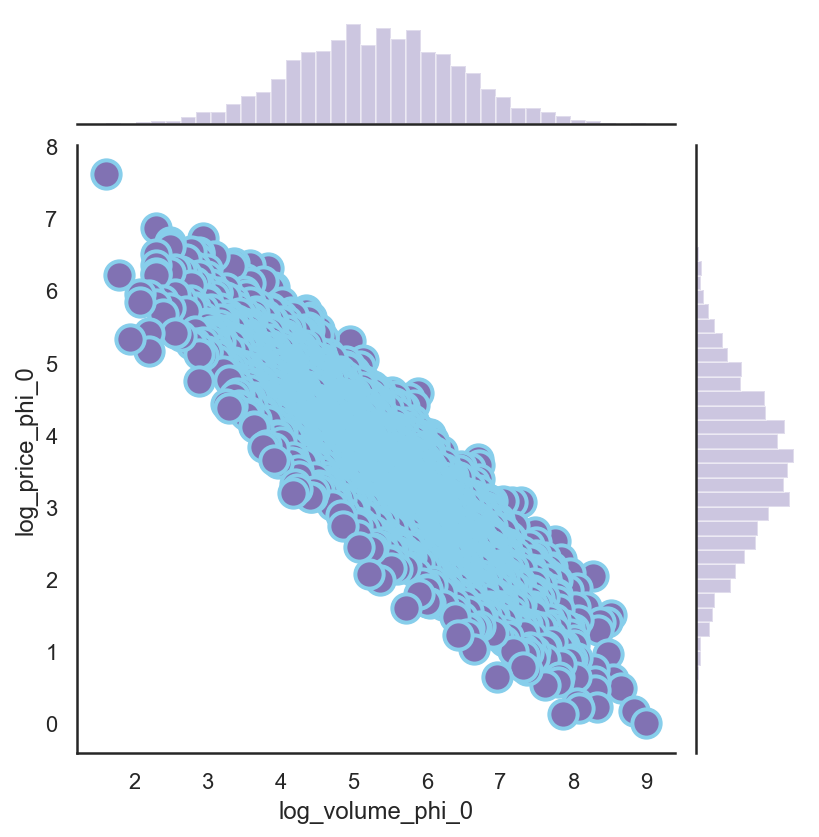

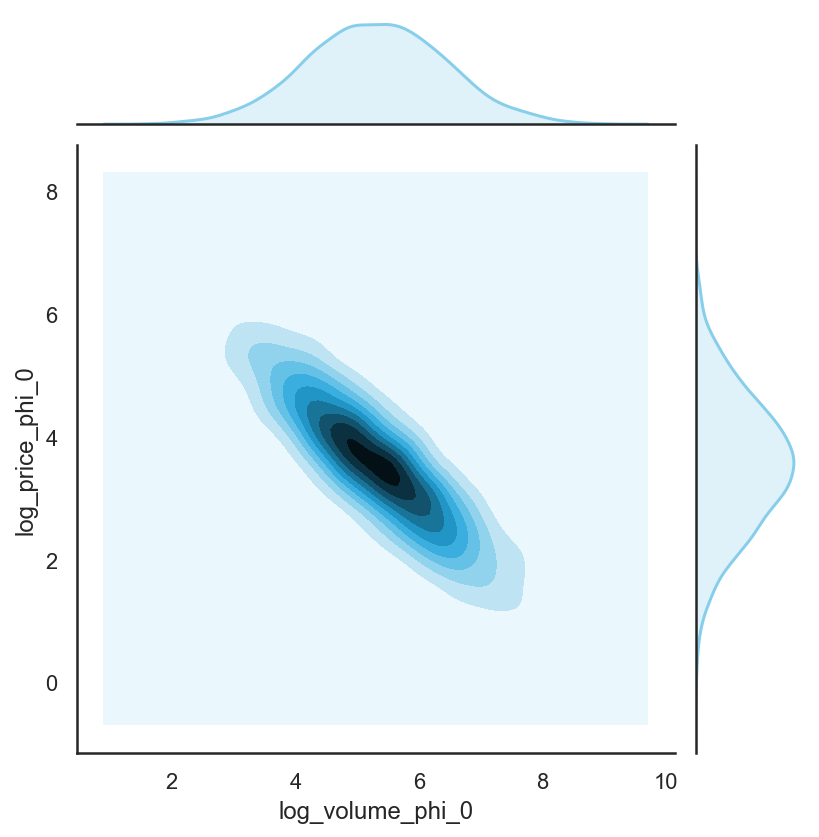

In [53]:
plot_data('log_volume', 'log_price', data, 0)

Using StandardScaler


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

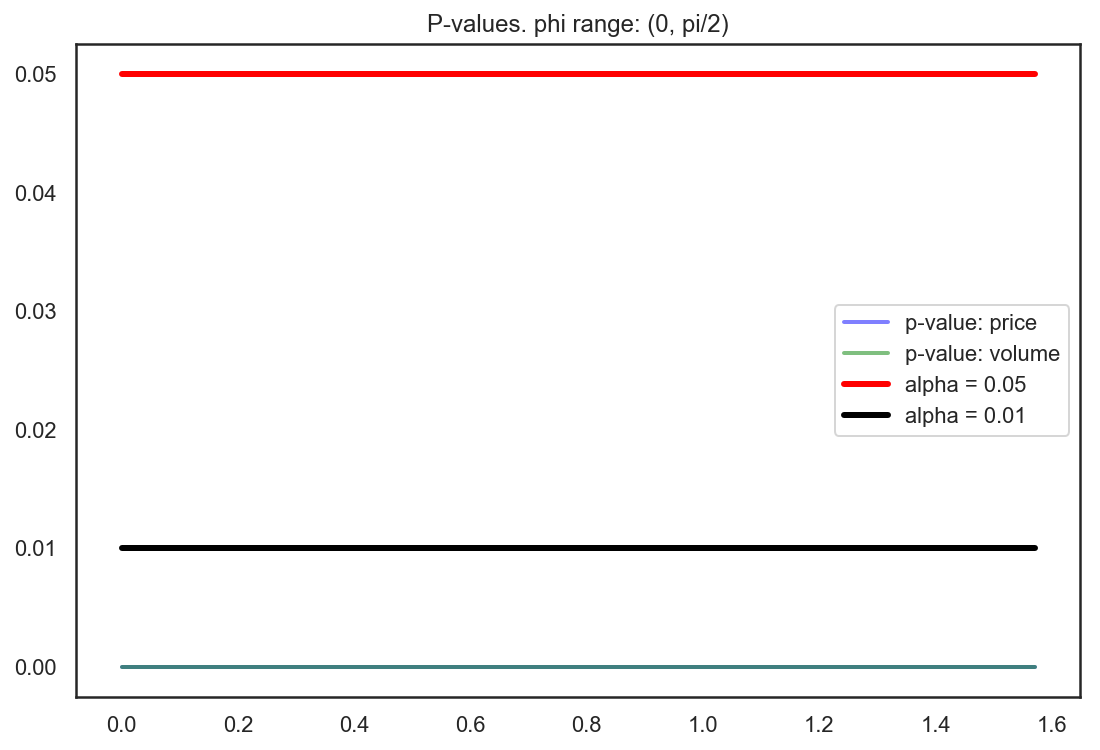

Wall time: 3.7 s


In [55]:
%%time
pv1, pv2 = get_pvalue_vecs(data['price'].values, data['volume'].values, phi_num = 1000, norm = True)
plot_pvals(pv1, pv2, 'price', 'volume')

Using StandardScaler


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

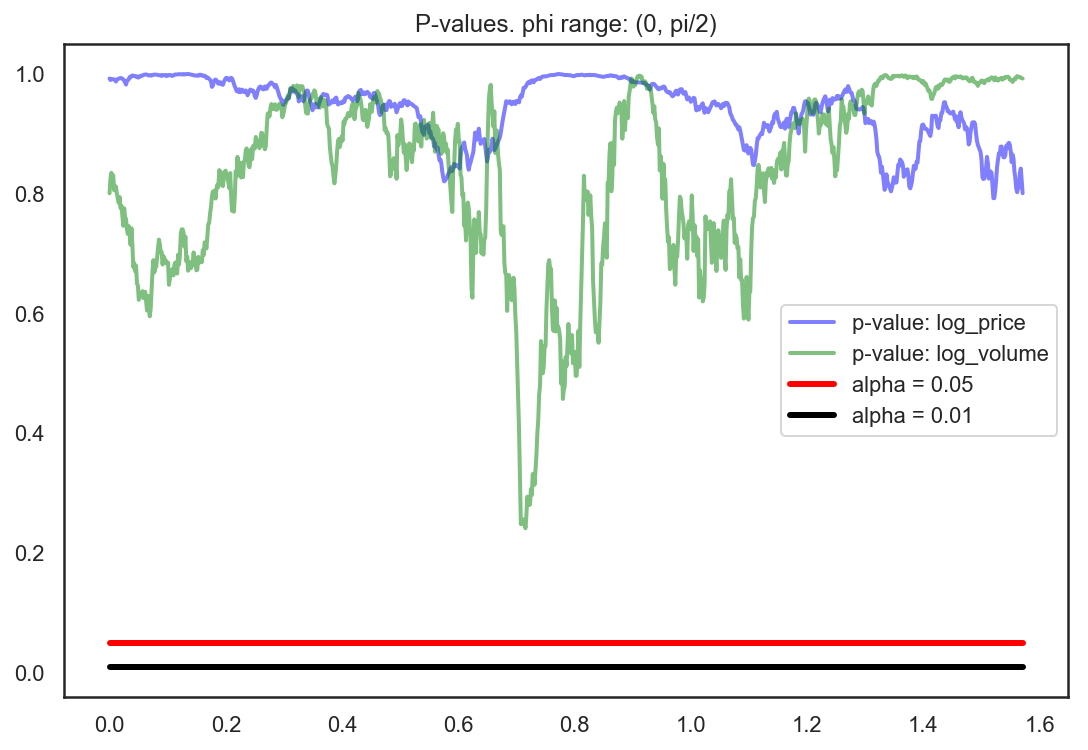

Wall time: 4.29 s


In [56]:
%%time
pv1, pv2 = get_pvalue_vecs(data['log_price'].values, data['log_volume'].values, phi_num = 1000, norm = True)
plot_pvals(pv1, pv2, 'log_price', 'log_volume')

__Контрольная проверка теста на случайных нормальных величинах__

In [66]:
rvs1 = sp.stats.norm.rvs(loc=0, scale=1, size=200)
rvs2 = sp.stats.norm.rvs(loc=0, scale=1, size=200)

In [67]:
print('KS-statistic D = %6.3f pvalue = %6.4f' % sp.stats.kstest(rvs1, 'norm'))
print('KS-statistic D = %6.3f pvalue = %6.4f' % sp.stats.kstest(rvs2, 'norm'))

KS-statistic D =  0.074 pvalue = 0.2134
KS-statistic D =  0.035 pvalue = 0.9666


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

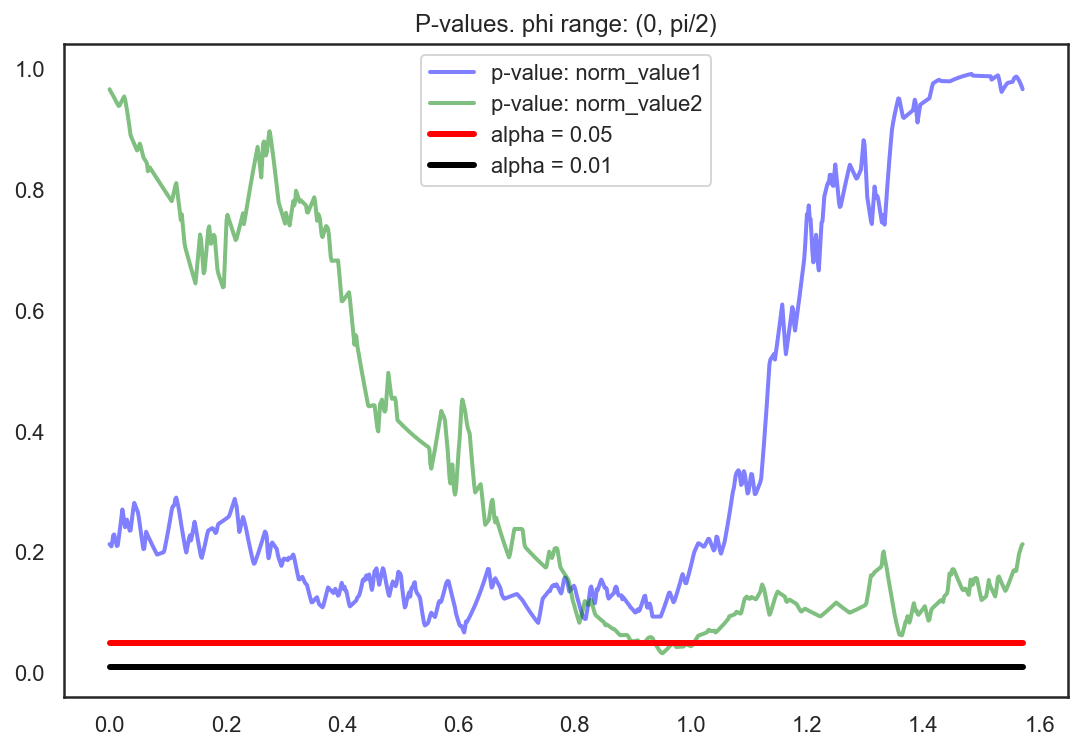

Wall time: 2.28 s


In [68]:
%%time
pv1, pv2 = get_pvalue_vecs(rvs1, rvs2, phi_num = 1000, norm = False)
plot_pvals(pv1, pv2, 'norm_value1', 'norm_value2')